# Astro 528, Lab 6, Exercise 2
## Parallelization for Multi-Core Workstations (using multiple processes)

### Hardware configuration for this exercise
In this lab exercise, we'll explore a few different ways that we can parallelize calculations across multiple cores of a single workstation or server.  Some of the syntax and programming patterns are very similar as to what you'll use later when we parallelize our code for distributed computing (i.e., over a number of processors that do not have direct access to the same memory.)

Fortunately, most modern workstations and even laptops have multiple cores.  As of 2021, most of the ICS-ACI compute nodes have 14-24 cores.  (The high-memory nodes have 40 cores. The HPRC nodes are configured to offer many more virtual cores, but HPRC jobs should not use more than 20 cores.)  

For this exercise, it's important that you actually have access to multiple processor cores.  If you're using Julia installed on your own machine, then you don't need to do anything special before starting the lab.  However, if you're using the ICDS-ACI portal to access the Jupyter Lab server, then you will need to have requested multiple processor cores when you first submited the request for the JupyterLab server using the box labeled "Number of Cores", i.e. _before you start executing cells in this notebook_.  Here's a [screenshot](images/portal_screenshot.png) showing the screen where you specify multiple cores.  

While we're in class, please ask for just 4 cores, since there are many of us using the same two compute nodes at once.  
If you return to working on the lab outside of class (and not right before the deadline), then feel free to try benchmarking the code using 8 cores, 12 or even 16 cores.  If you do ask for several cores, then please be extra diligent about deleting your session via the ICDS-ACI Portal when you're done, so they become avaliable to other members of the class.

### Why Jupyter?
For this exercise, we're using a Jupyter notebook, instead of a Pluto notebook.  Why?
In the previous exercise, we parallelized our code using one process that organized its computation into multiple threads, all within a Pluto notebook.  Pluto worked well for that kind of parallelism.  In contrast, for this exercise, we're going to parallelize our code using multiple processes. 
Pluto already uses multiple processes to analyze, run and display the Pluto notebook, so you can't (easily) parallelize your code over multiple processes within a Pluto notebook environment.  

Since each Jupyter notebook is executed using a separate Julia kernel, they are more ammenable to parallelization via multiple processes.  

### Multi-process vs Multi-threading
As discussed in [the previous exercise](https://psuastro528.github.io/lab6-start/ex1.html), both approaches are viable ways to parallelize code over multiple processors contained within one workstation/compute node/server.  Multiple threads within a single process all have access to the memory that the operating system (OS) has assigned to that process.  However, different processes are assigned separate memory locations.  While it is possible to send data from one process to another, it needs to be done explicitly.  For simples codes, I usually start with multi-threading, as it tends to be a little easier to implement and is often more efficient.  For more complex codes (e.g., integrating PDEs), there can be advanages to using multiple processes (e.g., reducing need for memory locks).  However, the main reason I want students to get experience parallelizing code using multiple processes is that this apporach is necessary to scale up the level parallelism to use more compute cores than exist in compute node.  If we write (and test) our code to run in parallel using multiple processes on one workstation, then there will be relatively little work to implement a distributed memory parallelization.  

### Installing packages
First, let's make sure that the packages we'll use are installed.

In [1]:
using Pkg
Pkg.UPDATED_REGISTRY_THIS_SESSION[] = true   # Tell Julia package manager not to download an updated registry for speed's sake
Pkg.activate(".")                            # Project.toml specifies the packages required for this lab
Pkg.instantiate()                            # Install any packages needed

  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


### Getting setup for parallel computation

First, let us load Julia's `Distributed` module that provides much of the needed functionality.

In [2]:
using Distributed
nworkers()

1

Note that even if you have a Jupyter notebook server (or remote desktop or PBS job) that has been allocated multiple cores, that doesn't mean that you'll use them.  By default, Julia starts running on a single core which is the one worker process.  
To enable parallel computing, we need to tell Julia how many processor cores to use.  By default, we're just using one.  How many should we add?  
Let's get some information about the hardware that we're running on.

In [3]:
Sys.cpu_summary()

Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz: 
          speed         user         nice          sys         idle          irq
#1-28  2980 MHz    2195181 s      11846 s    1251347 s  617866868 s          0 s


As discussed in exercise 1, just because the compute node we've been assigned has many cores, doesn't mean that we're allowed to use all of them.  
We'll check if this notebook is running inside a PBS job, and if so, use the number of cores that we've been assigned.  If we're not inside a PBS job, then we'll use the number of physical cores. 

In [4]:
using CpuId

In [5]:
if haskey(ENV,"PBS_NUM_PPN")
    pbs_procs_per_node = parse(Int64,ENV["PBS_NUM_PPN"])
    num_cores_to_use = pbs_procs_per_node 
else
    num_physical_cores = cpucores()
    num_cores_to_use = num_physical_cores 
end

8

2a.  How many cores will you be using for this exercise (i.e., the result of cell above)? 

In [31]:
response_2a = missing # Explicilty set to integer (i.e., don't set to num_cores_to_use, so we'll be able to provide appropriate feedback on your future responces.)

missing

Next, we'll tell Julia to add several worker processes. 

In [6]:
if num_cores_to_use>1
    addprocs(num_cores_to_use-1)
end

7-element Vector{Int64}:
 2
 3
 4
 5
 6
 7
 8

`addprocs(N)` returned a list of ids that you can use to refer to specific workers within Julia.  (We won't be using these, but it can be useful if you want finer grained control.)  
If you're every unsure of how many workers you currently have avaliable, you can run `nworkers()`.

In [30]:
nworkers()

7

Note that the list of workers now excludes 1 and the number of workers is equal to the number you added, rather than being one plus that number.  Why?  The original process is now in charge of delegating the work amongst the worker processes. (Historically, this process was referred to as the "master process", and you're likely to still that terminology in online documentation and questions.  I'll try to use the "delegator process" instead.)  When you have a lot of workers, it's often advantageous to let one process focus on managing all the communications and other overhead associated with parallelization.  That way the worker processes are likely to stay more nearly in sync, rather than having to repeatedly wait for the delegator process to catch up.  On the other hand, if there is relatively little overhead work for the delegator process, then it is often useful to set the number of workers equal to the number of available CPU cores, even though that means one process will have to do a little more work than the others.  We'll try both below.

### Loading Packages and modules

Now, that we have loaded the `Distributed` package, we can use the functions and macros that it provides to start code and packages that we want to use during this exercise onto the other processes.  Unlike when we were using multi-threading, with distributed computing each worker has its own chunk of memory and the programmer can control whether code is to be loaded on every process or just one/some.  
But before we load packages onto worker processes, we need to make sure that each worker is using the same environment (i.e., knows which versions of which packages should be avaliable).  We'll do that by telling each worker to activate the same environment, as specificed in the lab's `Project.toml` file.  
In this case, we don't need to install or instantiate on each worker, since we already installed them above, and on ICDS-ACI, each worker have access to the same filesystem.  (We also signal that workers should not attempt to update the Julia package registry.  Asking multiple processes to try to update the reigstry at once would be annoyingly slow (and I worry that it might even cause your Julia depot to get messed up).)

In [8]:
@everywhere using Pkg
@everywhere Pkg.UPDATED_REGISTRY_THIS_SESSION[] = true
@everywhere Pkg.activate(".")

  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


      From worker 3:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 2:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 7:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 4:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 5:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 8:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 6:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


Next, we want the packages that we plan to use for our computations below to be loaded and in scope on each worker.  In order to make sure that we don't trigger multiple worker processes trying to precompile packages at once, we'll first have the delegator process precompile all the packages used in this exercise. 

In [9]:
Pkg.precompile()

Precompiling project...
  ✓ lab6
1 dependency successfully precompiled in 4 seconds (158 already precompiled)


Again, we'll use the `@everywhere` macro in front of the `using` statement to load packages on both the delegator and worker processes.  

In [10]:
@everywhere using Distributions 

Typing `@everywhere` in front of every line of code would get very annoying fast.  So it's better to put the common code that you want every worker to load into a separate file (and even better is to organize the code into one or more modules or packages).  Then, we can load a whole bunch of functions that we'll want to use with one line.
In this exercise, we'll load the same code as in exercise 1 of this lab.  (As before, you don't need to review all the code in `src` unless you find it interesting or useful to see the programming patterns being demonstrated.)  The main difference in this exercise is that we'll include the file `src/lab6.jl` instead of the file `model_spectrum.jl`. `lab6.jl` includes the code from `model_spectrum.jl` (and the other files that it includes) and wraps them in a module named `lab6`.  (In contrast, Pluto's `ingredients` command automatically wraps code from a file into a module and returns it, so that Pluto can keep track of dependancies, which it needs to do to make a reactive notebook.)  
We preface the `include` with `@everywhere`, since we want all of the processors to be able to make use of these function and types.

In [11]:
@everywhere include("src/lab6.jl")

      From worker 3:	WARNING: replacing module lab6.
      From worker 4:	WARNING: replacing module lab6.
      From worker 2:	WARNING: replacing module lab6.
      From worker 7:	WARNING: replacing module lab6.
      From worker 6:	WARNING: replacing module lab6.
      From worker 5:	WARNING: replacing module lab6.
      From worker 8:	WARNING: replacing module lab6.


Now, we'll bring that module into scope.  Note that since this is not a package, we need to include a `.` to tell Julia that it can the module in the current namespace, rather than needing to load a package.

In [12]:
using .lab6

### Initialize data to be analyzed
In this exercise, we're going to create a model spectrum consisting of continuum, stellar absorption lines, telluric absorption lines.  
The `ModelSpectrum` module provides a `SimulatedSpectrum` type, but we'll need to initialize a variable with some specific parameter values.  The function will do that for us.

In [13]:
"Create an object that provides a model for the raw spetrum (i.e., before entering the telescope)"
function make_spectrum_object(;lambda_min = 4500, lambda_max = 7500, flux_scale = 1.0,
        num_star_lines = 200, num_telluric_lines = 100, limit_line_effect = 10.0)

    continuum_param = flux_scale .* [1.0, 1e-5, -2e-8]
    
    star_line_locs = rand(Uniform(lambda_min,lambda_max),num_star_lines)
    star_line_widths = fill(1.0,num_star_lines)
    star_line_depths = rand(Uniform(0,1.0),num_star_lines)
    
    telluric_line_locs = rand(Uniform(lambda_min,lambda_max),num_telluric_lines)
    telluric_line_widths = fill(0.2,num_telluric_lines)
    telluric_line_depths = rand(Uniform(0,0.4),num_telluric_lines)

    SimulatedSpectrum(star_line_locs,star_line_widths,star_line_depths,telluric_line_locs,telluric_line_widths,telluric_line_depths,continuum_param=continuum_param,lambda_mid=0.5*(lambda_min+lambda_max),limit_line_effect=limit_line_effect)
end

Next, we: 
1. create a set of wavelengths to observe the spectrum at, 
2. call the function above to create a spectrum object, 
3. create an object containing a model for the point spread function, and 
4. create an object that can compute the convolution of our spectral model with the point spread function model.

In [14]:
# 1.  Pick range of of wavelength to work on.
lambda_min = 5000
lambda_max = 6000
# You may want to adjust the num_lambda to make things more/less computationally intensive
num_lambda = 8*1024
lambdas = collect(range(lambda_min,stop=lambda_max, length=num_lambda));

# 2.  Create a model  spectrum that we'll analyze below
raw_spectrum = make_spectrum_object(lambda_min=lambda_min,lambda_max=lambda_max)

# 3.  Create a model for the point spread function (PSF)
psf_widths  = [0.5, 1.0, 2.0]
psf_weights = [0.8, 0.15, 0.05]
psf_model = GaussianMixtureConvolutionKernel(psf_widths,psf_weights)

# 4. Create a model for the the convolution of thte raw spectrum with the PDF model
conv_spectrum = ConvolvedSpectrum(raw_spectrum,psf_model)

ConvolvedSpectrum{SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}, GaussianMixtureConvolutionKernel{Float64, Float64}}(SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}([5759.04461771341, 5935.216168919393, 5066.30770348079, 5787.915625594012, 5090.477095620626, 5208.49685604649, 5531.295061638182, 5806.214450860399, 5120.453111175745, 5878.7921954548165  …  5814.655632962704, 5685.3808609669, 5968.823465565812, 5543.9000036860725, 5650.480675494859, 5206.525206166321, 5439.718402341051, 5794.951926564469, 5981.331902169326, 5507.503731758521], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.9272722858920843, 0.4252553231807428, 0.7023625411051253, 0.2062303771679308, 0.9956458271841326, 0.7254980816889405, 0.277844784858845, 0.23368899116481612, 0.7131821160030223, 0.4810771900460751  …  0.014312588703146112, 0.5824895205412695

In [142]:
result_ref = conv_spectrum.(lambdas);

### Visualize what we've created

This is very similar to exercise 1.  If you'd like to plot the raw spectrum and the convolved spectrum to see what's going on, there's some plotting code below.  The cells with plots below require that you first load the `Plots` package.  If you are confident you know what it looks like, then you can save some time, by not loading the Plots package.
If you'd like to plot the spectrum model we'll be generating, then let go ahead and load the plots package now.
Since we don't need the worker processes to plot things, we don't need to load the Plots code on all the worker processes.  

In [15]:
using Plots

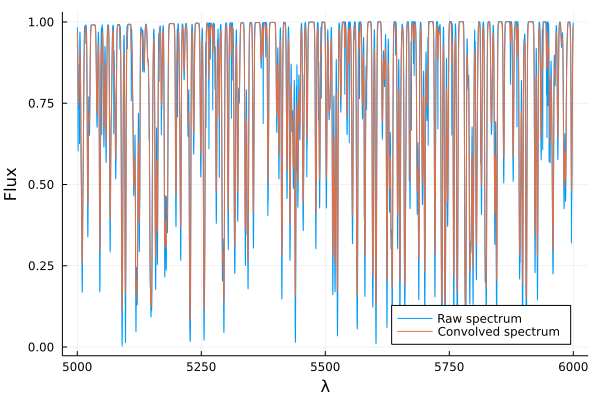

In [16]:
plot(lambdas,raw_spectrum.(lambdas),xlabel="λ", ylabel="Flux", label="Raw spectrum", legend=:bottomright)
plot!(lambdas,conv_spectrum.(lambdas), label="Convolved spectrum")

That's fairly crowded, you it may be useful to zoom in on a narrower range.

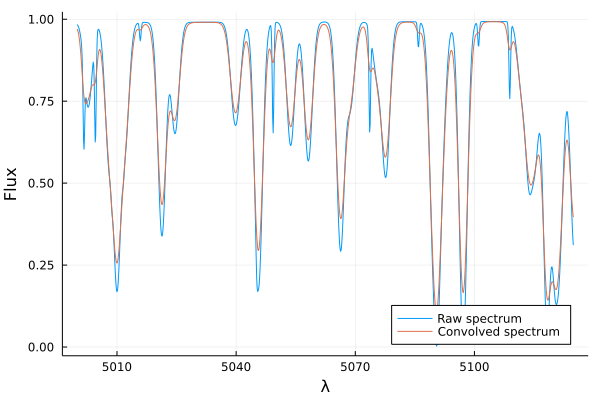

In [143]:
idx_plot = 1:min(1024,length(lambdas))
plot(lambdas[idx_plot],raw_spectrum.(lambdas[idx_plot]),xlabel="λ", ylabel="Flux", label="Raw spectrum", legend=:bottomright)
plot!(lambdas[idx_plot],result_ref[idx_plot], label="Convolved spectrum")

### Benchmarking serial code

First, let's benchmark the calculation of this spectrum on a single processor.  To keep things speedy, we'll time each method just a few times, rather than using `@btime`.

In [139]:
num_runs = 2

2

In [61]:
for i in 1:num_runs @time conv_spectrum(lambdas); end

  3.297228 seconds (5.80 M allocations: 828.104 MiB, 2.71% gc time, 2.14% compilation time)
  3.182834 seconds (5.54 M allocations: 811.591 MiB, 1.93% gc time)
  3.191187 seconds (5.54 M allocations: 811.591 MiB, 1.91% gc time)


Thinking back to [exercise 1](https://psuastro528.github.io/lab6-start/ex1.html), you may remember that we improved the performance by reducing memory allocations.  There were a few ways to do that, and we'll repeat just a few of them here for reference.

In [20]:
function compute_using_for_loop(x::AbstractArray, spectrum::T) where T<:AbstractSpectrum
    out = zeros(length(x))
    for i in 1:length(x)
        out[i] = conv_spectrum(x[i])
    end
    return out
end

compute_using_for_loop (generic function with 1 method)

In [21]:
for i in 1:num_runs @time compute_using_for_loop(lambdas,conv_spectrum) end

  0.885898 seconds (2.28 M allocations: 163.978 MiB, 3.65% gc time, 2.77% compilation time)
  0.868327 seconds (2.27 M allocations: 162.958 MiB, 4.16% gc time)
  0.857818 seconds (2.27 M allocations: 162.958 MiB, 2.60% gc time)


As before, writing the code as an explicit for loop significantly decreased the number of allocations and improved performance.

### Broadcasting
Thinking about to some previous labs, we made use of Julia's [dot syntax](https://docs.julialang.org/en/v1/manual/functions/#man-vectorized-1) to [\"broadcast\" and \"fuse\"](https://docs.julialang.org/en/v1/base/arrays/#Broadcast-and-vectorization-1) the array operation.

2b.  How do you expect the performance and memory allocations to compare to our for loop above?

In [32]:
response_2b = missing # INSERT response as String, e.g. "The same" or "50% faster".

missing

In [22]:
for i in 1:num_runs @time conv_spectrum.(lambdas); end

  0.869163 seconds (2.26 M allocations: 162.904 MiB, 3.93% gc time)
  0.851318 seconds (2.26 M allocations: 162.904 MiB, 2.62% gc time)
  0.864887 seconds (2.26 M allocations: 162.904 MiB, 2.58% gc time)


2c.  How did the results compare to your prediction?   If different, what could explain the difference(s)?  

In [33]:
response_2c = missing # INSERT response as String

missing

### map
Again, thinking back to the last exercise, a very useful and closely related programming pattern is [map](https://docs.julialang.org/en/v1/base/collections/#Base.map) (or [mapreduce](https://docs.julialang.org/en/v1/base/collections/#Base.mapreduce-Tuple{Any,Any,Any})).  `map(func,collection)` applies func to every element of the collection and returns a collection similar in size to collection.  

In [23]:
for i in 1:num_runs @time map(conv_spectrum,lambdas) end

  0.896989 seconds (2.31 M allocations: 165.642 MiB, 3.13% gc time, 4.55% compilation time)
  0.864507 seconds (2.26 M allocations: 162.779 MiB, 2.87% gc time)
  0.863779 seconds (2.26 M allocations: 162.779 MiB, 3.93% gc time)


The performance of map results should be very similar to the broadcasted and fused version above.  
Before we start parallelizing code, let's increase the number of times we'll benchmark each function.

In [140]:
num_runs = 5

5

Notice that `num_runs` has now been set to two different values at different parts of this notebook.  The value of `num_runs` will depend on which of the cells has been run most recently.
Sometimes, it can be conveneient to change a variable like this.  But it also makes it very easy to confuse yourself.  E.g., the code that you see in the notebook at any time is no longer guarenteed to be a complete representation of what the computer has computed.  

(In previous semesters, when I used Jupyter notebooks, by far the most common problem students encountered was running cells out of order and getting into some unintended state.  So my first suggestion was nearly always "Restart your kernel and step through the notebook in order."  While that's not a big deal for small notebooks, it can quickly become tediuos and time consuming.  Pluto solved that problem!  That's why I'm only using Jupyter for a few exercises that wouldn't work well with a Pluto notebook.)

LoadError: LoadError: UndefVarError: @test not defined
in expression starting at In[145]:1

### Parallelizing with pmap
If you can write your computations in terms of calling `map`, then one easy way to parallelize your code is to replace the call to `map` with a call to `pmap`, a parallel map.
If you only have one worker process, then it will still run in serial.  But if you have multiple workers, then `pmap` will parallelize your code.  When parallelizing code, it's always good to double check that your results are consistent with the reference implementation.

In [148]:
using Test
@test isapprox(pmap(conv_spectrum,lambdas), result_ref)

Test Passed

2d.  How much faster do you expect the code to run using `pmap`?

In [34]:
for i in 1:num_runs @time pmap(conv_spectrum,lambdas) end

  3.791174 seconds (4.11 M allocations: 291.095 MiB, 2.03% gc time, 27.28% compilation time)
  0.536929 seconds (707.13 k allocations: 86.949 MiB, 3.83% gc time)
  0.522642 seconds (707.16 k allocations: 86.951 MiB, 4.98% gc time)
  0.508952 seconds (707.22 k allocations: 86.951 MiB, 2.02% gc time)
  0.511752 seconds (707.10 k allocations: 86.948 MiB, 2.40% gc time)


In [35]:
for i in 1:num_runs @time pmap(x->conv_spectrum.(x),lambdas) end

  1.556305 seconds (1.41 M allocations: 72.840 MiB, 0.92% gc time, 28.42% compilation time)
  0.431909 seconds (495.84 k allocations: 19.376 MiB, 4.90% gc time)
  0.396931 seconds (495.67 k allocations: 19.370 MiB)
  0.400318 seconds (495.60 k allocations: 19.368 MiB)
  0.424178 seconds (495.58 k allocations: 19.368 MiB, 5.47% gc time)


2e.  By what speed-up factor did the wall time decrease for each of the two cases (ignoring the first call affected by compilation)?   How can you explain the difference?

In [36]:
response_2e = missing # INSERT responce as string

missing

You were likely disappointed in the speed-up factor.  What could have gone wrong?  In this case, we have a non-trivial, but still modest amount of work to do for each wavelength.  `pmap` distributes the work one element at a time.  The overhead in distributing the work and assembling the pieces likely ate into the potential performance gains.  To improve on this, we can tell `pmap` to distribute the work in batches.  Below, we'll specify a batch_size via an optional named parameter.

In [94]:
for i in 1:num_runs @time pmap(conv_spectrum,lambdas,batch_size=512) end

  0.292494 seconds (50.82 k allocations: 1.811 MiB)
  0.284662 seconds (50.93 k allocations: 1.820 MiB)
  0.298728 seconds (50.93 k allocations: 1.820 MiB, 7.32% gc time)
  0.295360 seconds (50.93 k allocations: 1.820 MiB)
  0.293948 seconds (50.93 k allocations: 1.820 MiB)


In [95]:
for i in 1:num_runs @time pmap(x->conv_spectrum.(x),lambdas,batch_size=512) end

  0.510169 seconds (316.92 k allocations: 17.395 MiB, 28.50% compilation time)
  0.289120 seconds (50.53 k allocations: 1.691 MiB)
  0.285926 seconds (50.53 k allocations: 1.690 MiB)
  0.285158 seconds (50.52 k allocations: 1.690 MiB)
  0.283380 seconds (50.53 k allocations: 1.691 MiB)


2f.  How much faster was the code using `pmap` with batches than the the serial version (focusing on the version using broadcasting)?  How does this compare to your original expectations?

In [46]:
response_2f = missing # INSERT responce as string

missing

Remember that we originally added one less worker processes than the number of physical cores avaliable to us.  Let's try adding one more worker process and comparing the performance.

In [48]:
if nworkers() < num_cores_to_use
    procs_without_code = addprocs(num_cores_to_use-nworkers())
end

1-element Vector{Int64}:
 9

In [49]:
procs_without_code

1-element Vector{Int64}:
 9

2g.  How long do you expect our function to take using `pmap` (using same batch size) now that we have one more worker process?

In [50]:
response_2g = missing # INSERT RESPONSE

missing

Let's test that.  But before we can, we'll need to load the code onto the recently added worker node.

In [55]:
@everywhere (using Pkg; Pkg.UPDATED_REGISTRY_THIS_SESSION[] = true; Pkg.activate("."))

      From worker 8:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 3:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 2:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 6:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 7:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 5:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`
      From worker 4:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


      From worker 9:	  Activating environment at `/storage/home/e/ebf11/Teach/Astro528/Fall2021/lab6-dev/Project.toml`


In [56]:
@everywhere using Distributions

We don't need/want to reread read and recompile our code on every worker node.  Instead, we'll use the [`@spawnat` macro](https://docs.julialang.org/en/v1/stdlib/Distributed/#Distributed.@spawnat) to tell julia to `include` our code only on specific processors.
`@spawnat` sends the code to the worker(s), but doesn't wait for the result.  Instead it gets a [Future](https://docs.julialang.org/en/v1/stdlib/Distributed/#Distributed.Future) that can be used to retreive the results when we need it by calling [`fetch`](https://docs.julialang.org/en/v1/stdlib/Distributed/#Base.fetch-Tuple{Distributed.Future}).  Here, we want to wait until the worker has finished loading the code, so we'll just do both in one line.

In [57]:
map(proc->fetch(@spawnat proc include("src/lab6.jl") ),  procs_without_code);

      From worker 9:	WARNING: replacing module lab6.


In [58]:
@everywhere using .lab6

In [149]:
@test isapprox(pmap(conv_spectrum,lambdas,batch_size=512), result_ref)

Test Passed

In [93]:
for i in 1:num_runs @time pmap(conv_spectrum,lambdas,batch_size=512) end

  0.286140 seconds (50.82 k allocations: 1.811 MiB)
  0.295901 seconds (50.93 k allocations: 1.820 MiB)
  0.285647 seconds (50.93 k allocations: 1.820 MiB)
  0.281314 seconds (50.93 k allocations: 1.820 MiB)
  0.278026 seconds (50.93 k allocations: 1.820 MiB)


2h.  How did the runtime compare when we used `pmap` with as many worker processes as physical cores avaliable compared to when we used one fewer worker processes than the number of physical cores avaliable?
How does this compare to your original expectations?   Try to explain any differences.

In [ ]:
response_2h = missing # INSERT RESPONSE

### Shared Arrays
Sometime the map programming pattern is limiting, inefficient, or just too cumbersome to use.  In these cases, it can be useful to define a [`SharedArray`](https://docs.julialang.org/en/v1.0/stdlib/SharedArrays/#Shared-Arrays-1).  A SharedArray is only possible when using a [shared memory system](https://en.wikipedia.org/wiki/Shared_memory), i.e., one computer has multiple processor cores that are all able to read and write data stored in a common memory system.   Data stored in a SharedArray is visible and accessible to every process.  A SharedArray also specifies which indices have been assigned to each worker process.  When an operation is to be parallelized, this information can be used to spread the work over the worker processes.  
(Note that code using SharedArray's can not run using processors split across multiple compute nodes, as we'll do in the next lab.) 

First, we'll create a SharedArray from our existing array of wavelengths.

In [63]:
using SharedArrays

In [64]:
lambdas_shared = SharedArray(lambdas)
typeof(lambdas_shared)

SharedVector{Float64} (alias for SharedArray{Float64, 1})

We apply `map` to a SharedArray just like to a regular Array, but the calculation is still performed in serial.

In [150]:
@test isapprox(map(conv_spectrum,lambdas_shared), result_ref)

Test Passed

In [65]:
for i in 1:num_runs @time map(conv_spectrum,lambdas_shared) end

  1.792326 seconds (4.60 M allocations: 330.959 MiB, 4.45% gc time, 2.45% compilation time)
  1.744523 seconds (4.52 M allocations: 326.338 MiB, 3.60% gc time)
  1.730317 seconds (4.52 M allocations: 326.338 MiB, 2.90% gc time)
  1.739779 seconds (4.52 M allocations: 326.338 MiB, 3.60% gc time)
  1.742719 seconds (4.52 M allocations: 326.338 MiB, 3.60% gc time)


Similarly, we can apply `pmap` to a SharedArray, and the calculation will be parallelized just like a regular Array.

In [66]:
for i in 1:num_runs @time pmap(conv_spectrum,lambdas_shared) end

  0.838092 seconds (1.41 M allocations: 128.461 MiB, 7.33% gc time, 32.42% compilation time)
  0.538854 seconds (706.92 k allocations: 86.935 MiB, 3.15% gc time)
  0.540950 seconds (706.88 k allocations: 86.933 MiB, 2.73% gc time)
  0.537545 seconds (707.03 k allocations: 86.939 MiB, 3.96% gc time)
  0.511410 seconds (706.88 k allocations: 86.933 MiB, 2.18% gc time)


As before, the performance wasn't particularly impressive.  

2i.  What do you suggest we do to improve the performance of `pmap` applied to a SharedArray?  

In [67]:
response_2i = missing # INSERT RESPONSE

missing

Try implementing and benchmarking your suggestion in the cell below.

In [227]:
# TODO:  Insert your code 

2j.  How did the performance compare to using `pmap` on regular Array (with similar optimizations)?  Is there anything fundamentally different about what the computer is doing that should affect the performance?

In [96]:
response_2j = missing # INSERT RESPONSE

missing

Pro tip:  There are fancy ways of initializing a SharedArray that can help minimize the number of allocations and spread the work of initializing the matrix over all the worker processes.  In case you're curious, I'll demonstrate below.  I find the syntax a little confusing, so I suggest skipping over this for now.  But you may want to return to it later if you want to initialize a SharedArray efficiently for your project.

In [98]:
# If we are initializing the array using values stored in a generic Array
function compute_by_initializing_shared_array(x::AbstractArray, spectrum::T) where T<:AbstractSpectrum
   SharedArray{Float64}(size(x), init = S-> S[SharedArrays.localindices(S)] .= spectrum.(view(x,SharedArrays.localindices(S))) )
end

#  If we are initializing the array using values already stored in a SharedArray, then assign work based on the input SharedArray
function compute_by_initializing_shared_array(x::SharedArray, spectrum::T) where T<:AbstractSpectrum
   SharedArray{Float64}(size(x), init = S-> S[SharedArrays.localindices(x)] .= spectrum.(view(x,SharedArrays.localindices(x))) )
end

compute_by_initializing_shared_array (generic function with 2 methods)

In [99]:
for i in 1:num_runs @time compute_by_initializing_shared_array(lambdas_shared,conv_spectrum) end

  1.304374 seconds (971.11 k allocations: 60.131 MiB, 1.58% gc time, 26.67% compilation time)
  0.274844 seconds (2.02 k allocations: 170.672 KiB)
  0.270967 seconds (2.03 k allocations: 171.812 KiB)
  0.273504 seconds (2.02 k allocations: 169.734 KiB)
  0.271373 seconds (2.03 k allocations: 170.344 KiB)


## Distributed Arrays
Sometimes, you want to spread the work over more processor cores than are available on a single workstation.  Or maybe you don't actually need the features of a SharedArray, so you want to write your code in a more general way, so that it could be parallelized on a [distributed memory system](https://en.wikipedia.org/wiki/Distributed_memory).  This can be useful even if your job could in principle be run on a single node with $N$ processor cores.  If you submit a job that requires $N$ processor cores on the same node, then your job is likely to wait in the queue longer than it you submit a job that requires $N$ processor cores that could be spread over multiple compute nodes.  If you want to make use a very large number of cores (e.g., using a cloud provider like Amazon AWS, Google Compute Engine, Microsoft Azure), then you'll need to use a distributed memory system.  For a long time, [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface) was the most common way to use distributed memory systems.  If you're programming with C/C++ or Fortran, then you will likely still be using MPI.  ([MPI.jl](https://github.com/JuliaParallel/MPI.jl) proivdes a wrapper for Julia to use most of the common MPI functions.)  Julia's [DistributedArrays.jl](https://juliaparallel.github.io/DistributedArrays.jl/latest/index.html) package is an attempt to make programming for distributed memory systems a little easier.  

Like for SharedArrays, there are several ways to initialize a `DistributedArray` (`DArray` for short) efficiently, where each workers initializes its own data.  Functions like `dzeros`, `dones`, `drand`, `drandn` and `dfill` act similarly to their counterparts without a `d` prefix, but create DArrays instead of regular Arrays.

Here we'll create a distributed array by simply applying `distribute` to our existing array of wavelengths.

In [104]:
@everywhere using DistributedArrays
lambdas_dist = distribute(lambdas)
typeof(lambdas_dist)
size(lambdas_dist)

(8192,)

As usual, the first time we call a function, it takes some extra time and memory to compile it.  So let's do that again, this time benchmarking the `distribute` operation.

In [105]:
@time lambdas_dist = distribute(lambdas);
typeof(lambdas_dist)

  0.000650 seconds (978 allocations: 175.906 KiB)


DArray{Float64, 1, Vector{Float64}}

In this case, distribute should be quite fast.  That's because we're creating a `DArray` on a shared memory system.  So the computer doesn't actually have to send communications over a network to access the data.  

When we apply map to a `DArray`, map parallelizes the calculation and returns the results in a `DArray`.  Each worker only operates on the subset of the array that is local to that worker process.  
We can view the part of the array that is local to each worker with `localpart()` and `localindices()`.  Note that none of the array was assigned to the delegator process.

In [130]:
fetch(@spawnat 1 (;indices=DistributedArrays.localindices(lambdas_dist),  values=localpart(lambdas_dist)) )

(indices = (1:0,), values = Float64[])

In [132]:
fetch(@spawnat first(workers()) (;indices=DistributedArrays.localindices(lambdas_dist),  values=localpart(lambdas_dist)) )

(indices = (1:1024,), values = [5000.0, 5000.12208521548, 5000.24417043096, 5000.3662556464415, 5000.488340861922, 5000.610426077402, 5000.732511292882, 5000.854596508363, 5000.976681723843, 5001.0987669393235  …  5123.794408497131, 5123.916493712612, 5124.038578928092, 5124.160664143572, 5124.282749359053, 5124.404834574533, 5124.526919790013, 5124.649005005494, 5124.771090220975, 5124.893175436455])

2k.  Before we benchmark this, what do you expect for the performance of `map` applied to DArray?

In [109]:
response_2k = missing # INSERT response 

missing

In [151]:
@test isapprox(map(conv_spectrum,lambdas_dist), result_ref)

Test Passed

In [152]:
for i in 1:num_runs @time map(conv_spectrum,lambdas_dist) end
typeof(map(conv_spectrum,lambdas_dist))

  0.267977 seconds (1.33 k allocations: 137.344 KiB)
  0.272009 seconds (1.44 k allocations: 147.172 KiB)
  0.273820 seconds (1.44 k allocations: 145.516 KiB)
  0.269379 seconds (1.45 k allocations: 146.281 KiB)
  0.271698 seconds (1.44 k allocations: 146.000 KiB)


DArray{Float64, 1, Vector{Float64}}

2l.  How did the actual performance compare to your expectations?

In [112]:
response_2l = missing # INSERT response 

missing

Since map returned a `DArray`, we shouldn't assume that all the data is avaliable to the master process.
In this case, we've only added processors that are on the same node, so we know that the data is actually all on one compute node.
But a `DArray` can't count on that being true.  Indeed, in a future exercise, we'll use multiple cores that are spread over multiple nodes.  
In order to bring make all the data in the DArray accessible to the master process, we could `collect` the data.

2m.  How do you expect the performance to compare when we run map on a `DArray` with and without collecting the data at the end?

In [114]:
response_2m = missing # INSERT response

missing

In [137]:
for i in 1:num_runs @time collect(map(conv_spectrum,lambdas_dist)) end

  0.898616 seconds (478.96 k allocations: 16.174 MiB)
  0.924482 seconds (479.09 k allocations: 16.188 MiB)
  0.940512 seconds (481.96 k allocations: 16.316 MiB, 1.73% gc time)
  0.901266 seconds (479.10 k allocations: 16.189 MiB)
  0.907086 seconds (479.09 k allocations: 16.188 MiB)


2n. How did the actual performance compare to your expectations?

In [138]:
response_2n = missing # INSERT response

missing

## Reducing Data Transport
Copying all that data back into one array for the master process to use added a significant amount to the total time.  If the data had to move over the network, then it would have taken even longer.
Fortunately, often you don't actually need to bring all the data back to the delegator process.  For example, you might have several calculations that can be done, each leaving the data distributed across many workers, until the very end.
Another common scenario is that you want to performing a task that can be phrased as a [`mapreduce`](https://en.wikipedia.org/wiki/MapReduce) programming pattern.  For example, imagine that we only wanted to compute the mean squared error between two models.  
For testing purposes, it'll be good to first implement it as a serial for loop.

In [154]:
function calc_mse_loop(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum,  v::Number)
    c = lab6.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    tmp1 = spec1(first(lambdas))
    tmp2 = spec2_shifted(first(lambdas))
    mse = zero(promote_type(typeof(tmp1),typeof(tmp2)))
    for i in eachindex(lambdas)
        @inbounds l = lambdas[i]
        flux1 = spec1(l)
        flux2 = spec2_shifted(l)
        mse += (flux1-flux2)^2
    end
    mse /= length(lambdas)
    return mse
end

calc_mse_loop (generic function with 1 method)

Now we'll implement the same calculation using mapreduce.

In [155]:
function calc_mse_mapreduce(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum,  v::Number)
    c = lab6.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    mse = mapreduce(x->(spec1(x)-spec2_shifted(x))^2, +, lambdas)
    mse /= length(lambdas)
end

calc_mse_mapreduce (generic function with 1 method)

When writing parallel code, it's always good to check that the results are consistent regardless of whether you compute in serial or parallel for some test cases.

In [157]:
@test calc_mse_loop(lambdas,conv_spectrum,conv_spectrum,10.0) ≈  calc_mse_mapreduce(lambdas,conv_spectrum,conv_spectrum,10.0) 

Test Passed

2o.  How do you expect the performance of `calc_mse_mapreduce` version will compare to twice the cost of applying `map` to `conv_spectrum` and the wavelengths stored as a `DArray`? 
How do you expect the performance of `calc_mse_mapreduce` version will compare to twice the cost of applying `map` to `conv_spectrum` and the wavelengths stored as a `DArray` *and* collecting the results to the delegator process?
(Remember, that calculating the mean squared error between two models involves evaluating two spectral models for each wavelength.)

In [158]:
response_2o = missing # INSERT response

missing

In [159]:
@time calc_mse_loop(lambdas,conv_spectrum,conv_spectrum,10.0) 
@time calc_mse_mapreduce(lambdas,conv_spectrum,conv_spectrum,10.0) 

  3.508425 seconds (8.98 M allocations: 651.638 MiB, 3.80% gc time)
  3.491763 seconds (8.98 M allocations: 651.554 MiB, 3.46% gc time)


7.939686081035728e-10

In [160]:
for i in 1:num_runs @time calc_mse_mapreduce(lambdas_dist,conv_spectrum,conv_spectrum,10.0) end

  1.026052 seconds (804.18 k allocations: 48.571 MiB, 1.56% gc time, 27.88% compilation time)
  0.539834 seconds (1.32 k allocations: 145.891 KiB)
  0.538430 seconds (1.32 k allocations: 145.828 KiB)
  0.535960 seconds (1.33 k allocations: 144.953 KiB)
  0.540800 seconds (1.32 k allocations: 145.828 KiB)


2o.  How did the actual performance compare to your expectations?

response_2o = missing # INSERT response

### Distributed for loops

While map, pmap and mapreduce can be very convenient, sometimes it's more natural to express your calculation in terms of a for loop.  We can do that with julia's [`@distributed`](https://docs.julialang.org/en/v1/stdlib/Distributed/#Distributed.@distributed) macro (with more explanation [here](https://docs.julialang.org/en/v1/manual/parallel-computing/#Parallel-Map-and-Loops-1)).  We'll try that below.

In [52]:
function compute_using_distributed_for_loop_unsynced(x::AbstractArray, spectrum::T) where T<:AbstractSpectrum
    out = zeros(length(x))  # Problematic since workers won't write to out on master
    @distributed for i in 1:length(x)
        out[i] = conv_spectrum(x[i])
    end
    return out
end

compute_using_distributed_for_loop_unsynced (generic function with 1 method)

In [53]:
for i in 1:num_runs @time res=   compute_using_distributed_for_loop_unsynced(lambdas_dist,conv_spectrum) end

  0.015375 seconds (20.85 k allocations: 1.323 MiB, 99.82% compilation time)
  0.000006 seconds (7 allocations: 32.531 KiB)
  0.000008 seconds (7 allocations: 32.531 KiB)


Wow, that was fast!  Or was it?  No.  Actually, what happened is that Julia started the computations on the workers, and let the master process keep going, without waiting for the workers to finish.  
Sometimes we want to do this, so the master processes can do other work while waiting on the workers to finish.  Also, each worker wrote to its own out array, so we didn't even get the output.  
For timing purposes, we want to make sure all the work is complete and the workers have synchronized.
We can do this by adding the [`@sync` macro](https://docs.julialang.org/en/v1/stdlib/Distributed/#Base.@sync).

In [162]:
function compute_using_distributed_for_loop(x::AbstractArray, spectrum::T) where T<:AbstractSpectrum
    out =  SharedArray(zeros(length(x)))
    @sync @distributed for i in 1:length(x)
        out[i] = conv_spectrum(x[i])
    end
    return out
end

compute_using_distributed_for_loop (generic function with 1 method)

In [166]:
@test isapprox( compute_using_distributed_for_loop(lambdas,conv_spectrum) , result_ref)

Test Passed

2p.  How do you expect the performance of `compute_using_distributed_for_loop` to compare to the performance of using `pmap` to compute the spectrum (after using a good base size)?

In [167]:
response_2p = missing # INSERT response

missing

In [172]:
for i in 1:num_runs @time compute_using_distributed_for_loop(lambdas_dist,conv_spectrum) end

  0.457005 seconds (55.83 k allocations: 3.325 MiB, 9.34% compilation time)
  0.278865 seconds (2.08 k allocations: 159.203 KiB)
  0.278020 seconds (2.08 k allocations: 159.172 KiB)
  0.275911 seconds (2.08 k allocations: 159.109 KiB)
  0.276224 seconds (2.08 k allocations: 159.781 KiB)


The `@distributed` macro also works with data stored in a SharedArray or even regular Array. For example...

In [173]:
for i in 1:num_runs @time compute_using_distributed_for_loop(lambdas_shared,conv_spectrum) end

  0.342240 seconds (56.01 k allocations: 3.339 MiB, 12.49% compilation time)
  0.274226 seconds (2.26 k allocations: 173.922 KiB)
  0.272958 seconds (2.26 k allocations: 173.312 KiB)
  0.272343 seconds (2.42 k allocations: 187.969 KiB)
  0.281497 seconds (2.26 k allocations: 173.953 KiB)


In [174]:
for i in 1:num_runs @time compute_using_distributed_for_loop(lambdas,conv_spectrum) end

  0.272496 seconds (1.97 k allocations: 150.359 KiB)
  0.271747 seconds (2.08 k allocations: 160.500 KiB)
  0.274466 seconds (2.08 k allocations: 160.203 KiB)
  0.274446 seconds (2.08 k allocations: 160.500 KiB)
  0.272727 seconds (2.08 k allocations: 159.500 KiB)


2q.  How did the benchmarking results compare to your predictions?

In [175]:
response_2q = missing # INSERT response

missing

In this case, we don't notice a significant difference in performance with the distributed for loop depending on how the lambdas were stored, since all three are being stored in a shared memory system.  Once we use multiple compute nodes and communications must travel over a network, differences in performance will become more apparent.

There's also an option to specify a reducing operation that is performed on the result of each pass through the `@distributed` for loop.  (The function to perform the reduction is provided in parentheses before the `for`.)

In [176]:
function calc_mse_distributed_loop(lambdas::DArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum,  v::Number)
    c = lab6.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    mse = @distributed (+) for i in eachindex(lambdas)
        @inbounds l = lambdas[i]
        flux1 = spec1(l)
        flux2 = spec2_shifted(l)
        (flux1-flux2)^2  # result of last line will be reduced by + operator
    end
    mse /= length(lambdas)
    return mse
end

calc_mse_distributed_loop (generic function with 1 method)

In [177]:
@test calc_mse_loop(lambdas,conv_spectrum,conv_spectrum,10.0) ≈ calc_mse_distributed_loop(lambdas_dist, conv_spectrum, conv_spectrum, 10.0) 

Test Passed

2r.  How do you expect that the performance of the `@distributed` for loop with a reduction operator will perform compared to `mapreduce` on a distributed array?

In [178]:
response_2r = missing # RESPONSE

missing

In [179]:
for i in 1:num_runs @time calc_mse_distributed_loop(lambdas_dist, conv_spectrum, conv_spectrum, 10.0) end

  0.543660 seconds (1.31 k allocations: 125.297 KiB)
  0.542247 seconds (1.42 k allocations: 133.734 KiB)
  0.540659 seconds (1.41 k allocations: 133.203 KiB)
  0.542365 seconds (1.42 k allocations: 135.078 KiB)
  0.540872 seconds (1.41 k allocations: 132.703 KiB)


2s.  How did the results compare to your expectations?

In [180]:
response_2s = missing # RESPONSE

missing

## Distributed for loop using FLoops

Here we'll demonstrate one more way to perform the same calculation in parallel, using the [FLoops.jl](https://juliafolds.github.io/FLoops.jl/dev/) package. This package is still young, experimental and likely to change.  But it seems to hold a lot of promise for enabling programmers to implement more complex calculations in parallel efficiently for the programmer, and hopefully eventually also efficiently for the computers. 

In [182]:
using FLoops

┌ Info: Precompiling FLoops [cc61a311-1640-44b5-9fba-1b764f453329]
└ @ Base loading.jl:1317


In [183]:
function calc_mse_flloop(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum,  v::Number; ex = ThreadedEx())
    c = lab6.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    tmp1 = spec1(first(lambdas))
    tmp2 = spec2_shifted(first(lambdas))
    mse = zero(promote_type(typeof(tmp1),typeof(tmp2)))
    @sync @floop ex for i in eachindex(lambdas)
        @inbounds l = lambdas[i]
        flux1 = spec1(l)
        flux2 = spec2_shifted(l)
        @reduce(mse += (flux1-flux2)^2)
    end
    mse /= length(lambdas)
    return mse
end

calc_mse_flloop (generic function with 1 method)

In [184]:
@test calc_mse_loop(lambdas,conv_spectrum,conv_spectrum,10.0) ≈ calc_mse_flloop(lambdas, conv_spectrum, conv_spectrum, 10.0, ex=DistributedEx()  ) 

Test Passed

In [185]:
for i in 1:num_runs @time calc_mse_flloop(lambdas, conv_spectrum, conv_spectrum, 10.0, ex=DistributedEx() ) end

  6.368498 seconds (306.63 k allocations: 17.197 MiB, 1.97% compilation time)
  0.979938 seconds (4.03 k allocations: 322.500 KiB)
  1.102403 seconds (4.24 k allocations: 331.625 KiB)
  0.919745 seconds (3.83 k allocations: 315.312 KiB)
  1.178537 seconds (3.94 k allocations: 319.484 KiB)


## Comparing Multi-threading vs Multi-processing performance more easily

Wouldn't it be nice if we didn't have to rewrite our code for each architectures?  There are some relatively young packages that make this possible (e.g., [FLoops.jl](https://juliafolds.github.io/FLoops.jl/dev/) and [KernelAbstractions.jl](https://juliagpu.github.io/KernelAbstractions.jl/stable/)).  Below we'll compare the performance of serial, multi-threaded and multi-processing versions of our function by simply specifying a different *executor*, as shown below.

In [189]:
for i in 1:num_runs @time calc_mse_flloop(lambdas, conv_spectrum, conv_spectrum, 10.0, ex = SequentialEx(simd = Val(true)) ) end

  3.608461 seconds (8.98 M allocations: 651.643 MiB, 5.65% gc time)
  3.545486 seconds (8.98 M allocations: 651.639 MiB, 3.94% gc time)
  3.556694 seconds (8.98 M allocations: 651.639 MiB, 3.93% gc time)
  3.529609 seconds (8.98 M allocations: 651.639 MiB, 3.51% gc time)
  3.543153 seconds (8.98 M allocations: 651.639 MiB, 3.93% gc time)


In [190]:
for i in 1:num_runs @time calc_mse_flloop(lambdas, conv_spectrum, conv_spectrum, 10.0, ex = ThreadedEx() ) end   # default if we don't specify ex explicitly

  0.650798 seconds (8.99 M allocations: 651.935 MiB, 16.59% gc time, 0.83% compilation time)
  0.727545 seconds (8.98 M allocations: 651.655 MiB, 26.03% gc time)
  0.910814 seconds (8.98 M allocations: 651.655 MiB, 41.01% gc time)
  0.726503 seconds (8.98 M allocations: 651.655 MiB, 26.12% gc time)
  0.731827 seconds (8.98 M allocations: 651.655 MiB, 26.29% gc time)


In [191]:
for i in 1:num_runs @time calc_mse_flloop(lambdas, conv_spectrum, conv_spectrum, 10.0, ex=DistributedEx() ) end

  0.607610 seconds (3.71 k allocations: 304.984 KiB)
  0.667173 seconds (3.82 k allocations: 314.188 KiB)
  0.632044 seconds (3.82 k allocations: 317.250 KiB)
  0.817953 seconds (3.82 k allocations: 313.609 KiB)
  0.606187 seconds (3.82 k allocations: 315.125 KiB)


When I last tested FLoops, it still wasn't as fast as using mapreduce on a distributed array or a distributed for loop for simple problems.  
But there may be some more complex problems, where the greater flexibility of FLoops is valuable to the programmer (e.g., if you have a large dataset and want to do several calculations using one pass through your data).

2t.  Think about your class project and the parallel programming patterns demonstrated in this exercise.  
Could your key calculation be phrased as a mapreduce problem?  Could it be phrased as one or more map calculations?  Is it advantageous to using a distributed for loop or FLoops?  
Do you see a reason to implement different parts of the problem using different programming patterns?
If you were to parallelize your code using multi-processing, which of the methods above would you choose?  Why?

In [228]:
response_2t = missing #= 
"""
Example 
multi-line
response
"""
=#;

2u.  *If* you're planning to parallelize your class project for distributed memory, then before you parallelize your class project, get some practice by parallelizing the function `calc_χ²` (at bottom of notebook) using whichever parallelization strategy that you plan to use for your project.

In [220]:
# response_u2: 
function calc_χ²_my_way(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum, σ1::AbstractArray, σ2::AbstractArray, v::Number; #= any optional parameters? =# )
    # INSERT YOUR CODE HERE
    return missing
end

calc_χ²_my_way (generic function with 1 method)

In [225]:
σ_obs1 = 0.02*ones(size(lambdas))
σ_obs2 = 0.02*ones(size(lambdas));

In [223]:
@test abs(calc_χ²_my_way(lambdas,conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 0.0 )) < 1e-8

Test Failed at In[223]:1
  Expression: abs(calc_χ²_my_way(lambdas, conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 0.0)) < 1.0e-8
   Evaluated: missing < 1.0e-8


LoadError: [91mThere was an error during testing[39m

In [224]:
@test calc_χ²_my_way(lambdas,conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 10.0 ) ≈ calc_χ²_loop(lambdas,conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 10.0 )

Error During Test at In[224]:1
  Test threw exception
  Expression: calc_χ²_my_way(lambdas, conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 10.0) ≈ calc_χ²_loop(lambdas, conv_spectrum, conv_spectrum, σ_obs1, σ_obs2, 10.0)
  MethodError: no method matching zero(::Type{Any})
  Closest candidates are:
    zero(::Type{Union{Missing, T}}) where T at missing.jl:105
    zero(::Union{Type{P}, P}) where P<:Dates.Period at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Dates/src/periods.jl:53
    zero(::AbstractIrrational) at irrationals.jl:148
    ...
  Stacktrace:
    [1] zero(#unused#::Type{Any})
      @ Base ./missing.jl:106
    [2] calc_χ²_loop(lambdas::Vector{Float64}, spec1::ConvolvedSpectrum{SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}, GaussianMixtureConvolutionKernel{Float64, Float64}}, spec2::ConvolvedSpectrum{SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}, Ga

LoadError: [91mThere was an error during testing[39m

In [226]:
function calc_χ²_loop(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum, σ1::AbstractArray, σ2::AbstractArray, v::Number )
    @assert size(lambdas) == size(σ1) == size(σ2)
    c = lab6.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    tmp1 = spec1(first(lambdas))
    tmp2 = spec2_shifted(first(lambdas))
    χ² = zero(promote_type(typeof(tmp1),typeof(tmp2),eltype(σ1),eltype(σ2)))
    for i in eachindex(lambdas)
        @inbounds l = lambdas[i]
        flux1 = spec1(l)
        flux2 = spec2_shifted(l)
        @inbounds χ² += (flux1-flux2)^2/(σ1[i]^2+σ2[i]^2)
    end
    return χ²
end

calc_χ²_loop (generic function with 1 method)